# All supported tasks

In [2]:
from transformers.pipelines import SUPPORTED_TASKS
for k,v in SUPPORTED_TASKS.items():
    print(k)

audio-classification
automatic-speech-recognition
text-to-audio
feature-extraction
text-classification
token-classification
question-answering
table-question-answering
visual-question-answering
document-question-answering
fill-mask
summarization
translation
text2text-generation
text-generation
zero-shot-classification
zero-shot-image-classification
zero-shot-audio-classification
conversational
image-classification
image-segmentation
image-to-text
object-detection
zero-shot-object-detection
depth-estimation
video-classification
mask-generation
image-to-image


# demo

In [22]:
from transformers import pipeline
checkpoint = "google/owlvit-base-patch32"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [23]:
??detector.__call__

Signature:
detector.__call__(
    image: Union[str, ForwardRef('Image.Image'), List[Dict[str, Any]]],
    candidate_labels: Union[str, List[str]] = None,
    **kwargs,
)
Source:   
    def __call__(
        self,
        image: Union[str, "Image.Image", List[Dict[str, Any]]],
        candidate_labels: Union[str, List[str]] = None,
        **kwargs,
    ):
        """
        Detect objects (bounding boxes & classes) in the image(s) passed as inputs.

        Args:
            image (`str`, `PIL.Image` or `List[Dict[str, Any]]`):
                The pipeline handles three types of images:

                - A string containing an http url pointing to an image
                - A string containing a local path to an image
                - An image loaded in PIL directly

                You can use this parameter to send directly a list of images, or a dataset or a generator like so:

                ```python
                >>> from transformers import pipeline

                >>> de

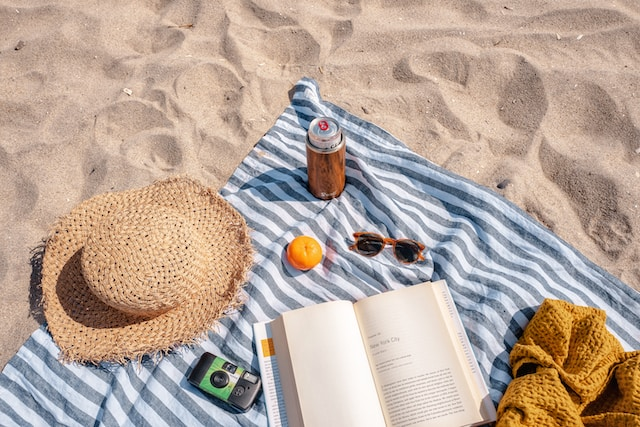

In [24]:
import requests
from PIL import Image

url = "https://unsplash.com/photos/oj0zeY2Ltk4/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTR8fHBpY25pY3xlbnwwfHx8fDE2Nzc0OTE1NDk&force=true&w=640"
im = Image.open(requests.get(url, stream=True).raw)
im

In [39]:
predictions = detector(
    im,
    candidate_labels=["hat", "sunglasses", "book", "orange"],
)
predictions
# orange is not detected

[{'score': 0.22562037408351898,
  'label': 'sunglasses',
  'box': {'xmin': 349, 'ymin': 228, 'xmax': 429, 'ymax': 265}},
 {'score': 0.15738719701766968,
  'label': 'book',
  'box': {'xmin': 270, 'ymin': 284, 'xmax': 503, 'ymax': 427}},
 {'score': 0.10808277130126953,
  'label': 'hat',
  'box': {'xmin': 38, 'ymin': 172, 'xmax': 260, 'ymax': 363}}]

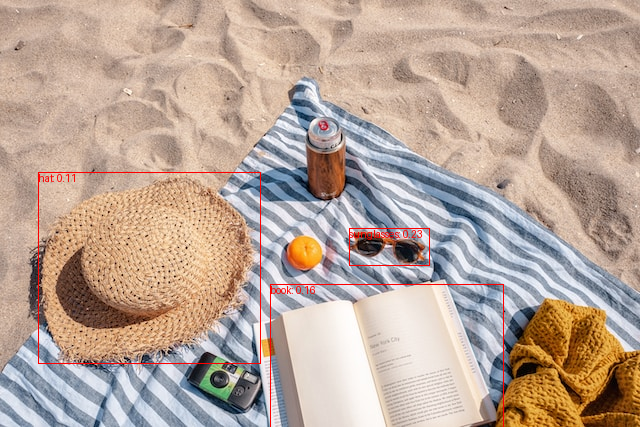

In [40]:
from PIL import ImageDraw

draw = ImageDraw.Draw(im)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]
    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="red")

im

# Pipeline implementation

## load the model + tokenizer

In [48]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
checkpoint = "uer/roberta-base-finetuned-dianping-chinese"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

## input process

In [46]:
input_text = "我觉得不太行！"
inputs = tokenizer(input_text, return_tensors="pt")
for k,v in inputs.items():
    print(k,v)

input_ids tensor([[ 101, 2769, 6230, 2533,  679, 1922, 6121, 8013,  102]])
token_type_ids tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])


## model prediction

In [49]:
res = model(**inputs)
res

SequenceClassifierOutput(loss=None, logits=tensor([[ 1.7376, -1.8681]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [50]:
from torch import  softmax
logits = res.logits
logits = softmax(logits, dim=1)
logits

tensor([[0.9736, 0.0264]], grad_fn=<SoftmaxBackward0>)

## get output

In [57]:
import torch
pred = torch.argmax(logits, dim=1).item()
pred

0

In [53]:
model.config.id2label

{0: 'negative (stars 1, 2 and 3)', 1: 'positive (stars 4 and 5)'}

In [58]:
results = model.config.id2label.get(pred)
results

'negative (stars 1, 2 and 3)'